In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

In [3]:
data2 = pd.read_csv("gz2sample_with_images.csv")

In [4]:
data2.head()

,ID,Right Ascension,Declination,Radius50,Radius90,Brightness_U,Brightness_G,Brightness_R,Brightness_I,Brightness_Z,...,Err_Corrected_R,Err_Corrected_I,Err_Corrected_Z,PETROR50_R_KPC,Color,Morphology,Uncertain,Elliptical,Spiral,images
0,154,170.805579,-1.182146,0.322703,0.283528,19.361341,17.737705,0.730947,16.445162,16.151276,...,0.013468,0.014121,0.024163,4.196238,-0.070320,-1.209384,1,0,0,587722981736054938.jpg
1,27,170.945892,-1.108325,3.478471,2.835676,31.566551,37.952810,-1.891493,35.954224,29.191177,...,0.013468,0.014121,0.024163,4.196238,13.974188,-1.209384,1,0,0,587722981736120347.jpg
2,35,171.990936,-1.214009,1.627649,1.146504,17.994175,16.808289,-0.718298,15.409781,15.245371,...,0.013468,0.014121,0.024163,4.196238,0.071563,-1.209384,1,0,0,587722981736579107.jpg
3,101,177.631858,-1.105126,-0.228276,-0.050754,20.127234,18.129680,0.590385,16.327341,15.979728,...,0.013468,0.014121,0.024163,4.196238,0.247015,0.458732,0,1,0,587722981739069541.jpg
4,94,182.925262,-1.092357,-0.310850,-0.175330,19.045778,17.276037,0.061474,15.985344,15.641546,...,0.013804,0.014019,0.019940,3.973422,-0.025134,0.458732,0,1,0,587722981741363294.jpg


In [5]:
from sklearn.preprocessing import StandardScaler

feature = [
    "Radius50",
    "Radius90",
    "Brightness_R",
    "Redshift",
    "Color",
    "Morphology"
]

scaler = StandardScaler()
data2[feature] = scaler.fit_transform(data2[feature])

In [16]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os

In [7]:
features_array = data2[feature].values.astype(np.float32)  

print(features_array.dtype) 
print(features_array.shape) 

float32
(200, 6)


In [11]:
class galaxy_dataset(Dataset):
    def __init__(self, data, features_array, img_path):
        self.data = data.reset_index(drop=True) 
        self.features_array = features_array
        self.img_path = img_path
        self.feature = feature

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # getting the images path
        img_file_column = "images"
        img_full_path = os.path.join(self.img_path, row[img_file_column])

        # opening and reading the image
        image = Image.open(img_full_path).convert("RGB")
        image = np.array(image) / 255.0
        image = torch.tensor(image, dtype=torch.float32)
        image = image.permute(2, 0, 1)  # (C, H, W)

        features = torch.tensor(row[self.feature].values.astype(np.float32), dtype=torch.float32)
        
        return image, features

In [12]:
dataset = galaxy_dataset(
    data2,
    features_array,  
    r"D:/Nazanin/programming/galaxy project/images"
)

In [13]:
dataloader = DataLoader(
    dataset,
    batch_size=4,   #as long as the images are large
    shuffle=True
)

In [ ]:
img, feat = next(iter(dataloader))

print(img.shape)
print(feat.shape)  

torch.Size([4, 3, 256, 256])
torch.Size([4, 6])


ENCODER:

In [17]:
import torch.nn as nn

In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.conv = nn.Sequential(
            # (3, 256, 256) → (32, 128, 128)
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (32, 128, 128) → (64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (64, 64, 64) → (128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (128, 32, 32) → (256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()

        # 256 × 16 × 16 = 65536
        self.fc = nn.Linear(256 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        z = self.fc(x)
        return z

In [ ]:
encoder = Encoder(latent_dim=128)

img, feat = next(iter(dataloader))

z_img = encoder(img)

print(img.shape)
print(z_img.shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 128])


conditioning with concat:

In [ ]:
z_cond = torch.cat([z_img, feat], dim=1)
print(z_cond.shape) 

#cause z_img is [4, 128] and feat is [4, 6] ---> so the resultt should be [batchsize=4 , 134 ]

torch.Size([4, 134])


DECODER:

In [22]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=134):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),

            nn.Linear(1024, 3 * 256 * 256),
            nn.Sigmoid()  #using this function instead of relu cause the pixeles are between 0 and 1
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 3, 256, 256)
        return x

In [23]:
decoder = Decoder(latent_dim=134)
out_img = decoder(z_cond)
print(out_img.shape)

torch.Size([4, 3, 256, 256])


learning rate:
checking out the suitable Lr for the model.

In [30]:
criterion = nn.MSELoss()

In [31]:
import torch.optim as optim

optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=0.001
)

In [32]:
encoder.train()
decoder.train()

for img, feat in dataloader:

    # encode
    z_img = encoder(img)
    # condition
    z_cond = torch.cat([z_img, feat], dim=1)
    #decode
    recon_img = decoder(z_cond)
    #loss
    loss = criterion(recon_img, img)
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("loss:", loss.item())
    break 


loss: 0.18458332121372223


In [ ]:
encoder.eval()
decoder.eval()

img, feat = next(iter(dataloader))  

# Encode
z_img = encoder(img)

# Condition
z_cond = torch.cat([z_img, feat], dim=1)

# Decode
recon_img = decoder(z_cond)

# Loss
loss = criterion(recon_img, img)

print("Test Loss:", loss.item())

#the closer trhe LOSS is to 0, the better is the model

Test Loss: 0.015050793997943401


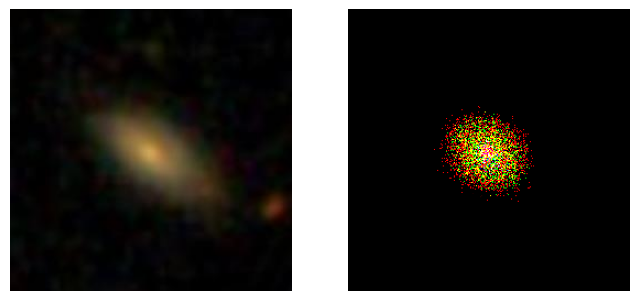

In [ ]:
import matplotlib.pyplot as plt

img, feat = next(iter(dataloader))  

z_img = encoder(img)
z_cond = torch.cat([z_img, feat], dim=1)
recon_img = decoder(z_cond)

orig = img[0].permute(1, 2, 0).detach().numpy()       # (C,H,W) -> (H,W,C)
recon = recon_img[0].permute(1, 2, 0).detach().numpy()

#comparing the reconstructed piture with the original galaxy
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(recon)
plt.axis("off")

plt.show()

# the squeezed picture vs the galaxy (the model could understand the most important parts of the image)

.......

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.eval()
decoder.eval()

img, feat = next(iter(dataloader))
img = img.to(device)
feat = feat.to(device)

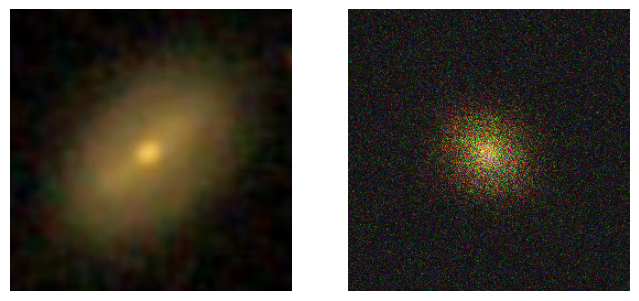

In [48]:
with torch.no_grad():
    z_img = encoder(img)
    z = torch.cat([z_img, feat], dim=1)
    recon_img = decoder(z)

orig = img[0].permute(1,2,0).cpu().numpy()
recon = recon_img[0].permute(1,2,0).cpu().numpy()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(recon)
plt.axis("off")

plt.show()

# the image is blured (that is what autoencoder does)

testing if the model has understood the features on the picture:

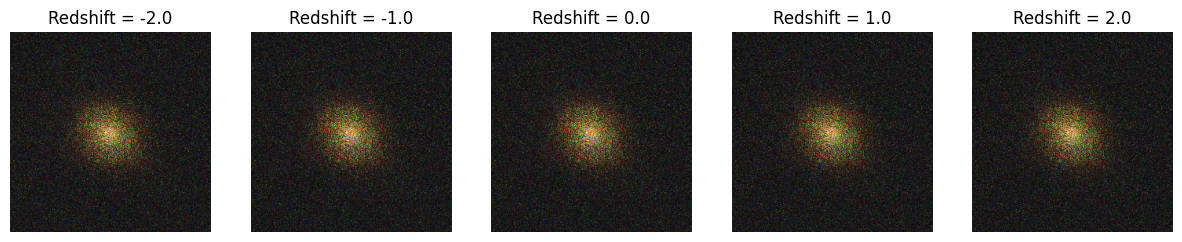

In [ ]:
img = img[0:1]     # working on just one picture
feat = feat[0:1]   

#changing redshift for checking the model:

redshift_values = [-2.0, -1.0, 0.0, 1.0, 2.0]

feature = [
    "Radius50",      # 0
    "Radius90",      # 1
    "Brightness_R",  # 2
    "Redshift",      # 3  
    "Color",         # 4
    "Morphology"     # 5
]
redshift_idx = 3


plt.figure(figsize=(15, 3))

for i, z_val in enumerate(redshift_values):

    feat_mod = feat.clone()
    feat_mod[0, redshift_idx] = z_val  #just changing the redshift

    with torch.no_grad():
        z_img = encoder(img)
        z_cond = torch.cat([z_img, feat_mod], dim=1)
        recon = decoder(z_cond)

    recon_np = recon[0].permute(1, 2, 0).cpu().numpy()

    plt.subplot(1, len(redshift_values), i+1)
    plt.imshow(recon_np)
    plt.title(f"Redshift = {z_val}")
    plt.axis("off")

plt.show()


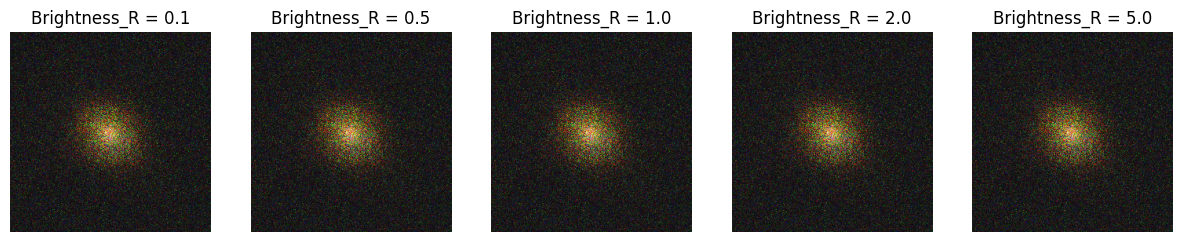

In [50]:
#testing again with brightness:

brightness_values = [0.1, 0.5, 1.0, 2.0, 5.0] 

brightness_idx = 2 

plt.figure(figsize=(15, 3))

for i, b_val in enumerate(brightness_values):

    feat_mod = feat.clone()
    feat_mod[0, brightness_idx] = b_val  

    with torch.no_grad():
        z_img = encoder(img)
        z_cond = torch.cat([z_img, feat_mod], dim=1)
        recon = decoder(z_cond)

    recon_np = recon[0].permute(1, 2, 0).cpu().numpy()

    plt.subplot(1, len(brightness_values), i+1)
    plt.imshow(recon_np)
    plt.title(f"Brightness_R = {b_val}")
    plt.axis("off")

plt.show()


the amount of change which is seen is not enough to be useful for us due to the GPU limitation (for the training part)